# Exercise 1

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.special import erfc
import os
from tqdm import tqdm
from numba import jit, prange

In [22]:
np.random.seed(42)
os.makedirs('media', exist_ok=True)

### 1.1 Vibrating string

A. (0.5 point) Discretize the wave equation, and write it in a form suitable for
implementing in a computer program. Assume that the boundaries are fixed, 	(x =
0, t) = 0, 	(x = L, t) = 0. L is the length of the string. Take L = 1 for simplicity.
Divide the string in N intervals, so that the interval length is x = L/N. Also
consider the boundary cases.

In [23]:
def solve_wave(psi_init, L, c, T, Nx, dt):
    """Solves the wave equation using the finite difference method (explicit scheme) and returns the vibration amplitude psi(x,t) matrix of all time steps.
    
    Args:
    psi_init (function): Initial condition function to generate psi(x,0)
    L (float): Length of the string
    c (float): Wave speed
    T (float): Total time to simulate
    Nx (int): Total number of spatial intervals
    dt (float): Time step size
    """
    # Discretization
    dx = L/Nx # spatial step size
    Nt = int(T/dt)+1 # Total number of time steps
    psi = np.zeros((Nx, Nt)) # Vibration amplitude psi(x,t) matrix
    x = np.linspace(0, L, Nx) # spatial grid

    # Initial conditions
    psi[:,0] = psi_init(x)
    psi[:,1] = (1+dt)*psi[:,0] # approximated state at t=1

    # Physical boundaries at x=0 and x=L
    psi[0,:] = 0
    psi[-1,:] = 0

    # Stepping through time
    for t in range(2, Nt):
        for x in range(1, Nx-1): # exclude simulating at boundaries
            psi[x, t] = c**2 * (dt**2)/(dx**2) * (psi[x+1, t-1] + psi[x-1, t-1] - 2*psi[x, t-1]) - psi[x, t-2] + 2*psi[x, t-1]
    
    return psi

# Parameters
L = 1  # Length of the string
c = 1  # Wave speed
psi_init = lambda x: np.sin(2 * np.pi * x)

# Discretization
Nx = 100  # Total number of spatial intervals
dx = L / Nx  # Spatial step size
Nt = 1000  # Number of time steps to simulate
dt = 0.001  # Time step size

psi_matrix = solve_wave(psi_init, L, c, Nt * dt, Nx, dt)
x = np.linspace(0, L, Nx)

B. (1 point) Implement the time stepping. Determine the time development of
the string, with the following initial conditions. The string is at rest at t = 0, i.e.
	′(x, t = 0) = 0.

i. 	(x, t = 0) = sin(2πx).

ii. 	(x, t = 0) = sin(5πx).

iii. 	(x, t = 0) = sin(5πx) if 1/5 < x < 2/5, else 	 = 0.

Take c = 1 and use the time step dt = 0.001. Plot the result at several times in
the same figure, e.g. varying the color of the curve.

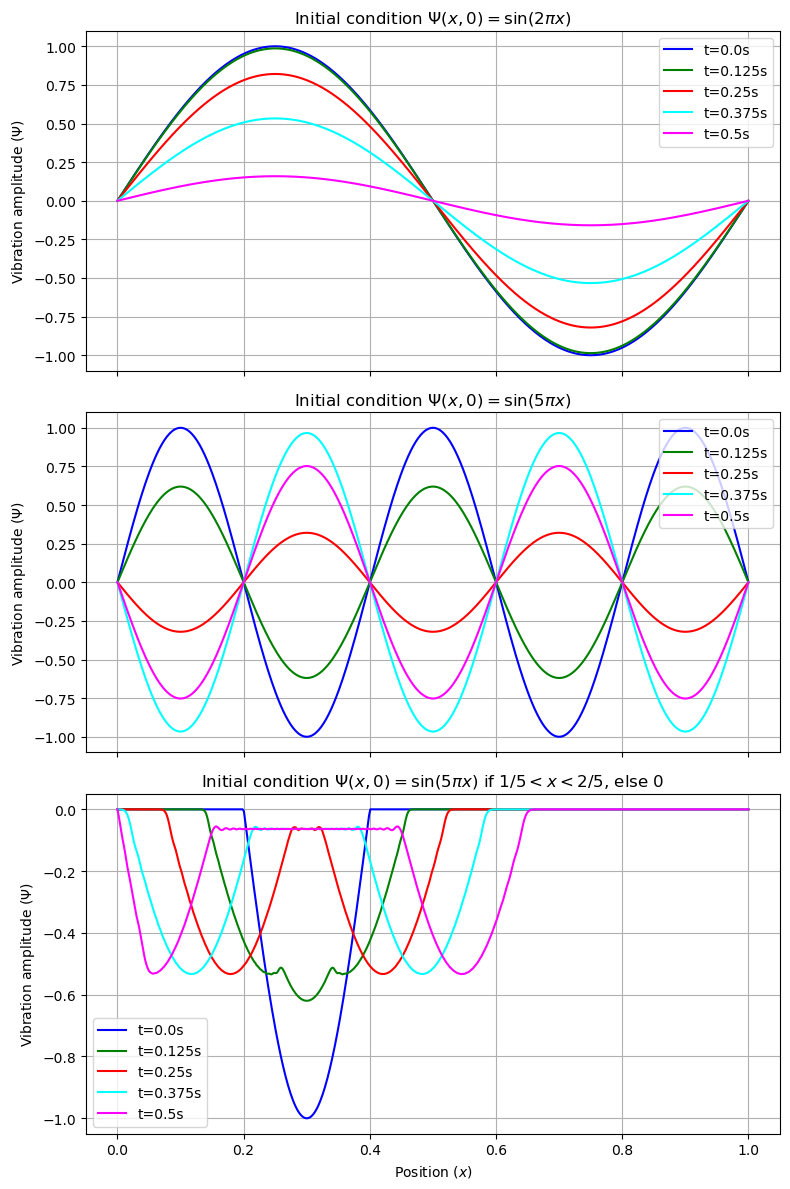

In [24]:
# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 0.5
Nx = 500
dx = L / Nx
Nt = int(T / dt)

init_conditions = [
    lambda x: np.sin(2 * np.pi * x),
    lambda x: np.sin(5 * np.pi * x),
    lambda x: np.where((1/5 < x) & (x < 2/5), np.sin(5 * np.pi * x), 0)
]

init_labels = [
    '$\\sin(2\\pi x)$',
    '$\\sin(5\\pi x)$',
    '$\\sin(5\\pi x)$ if $1/5 < x < 2/5$, else $0$'
]

psis = []
for i, (f0, init_label) in enumerate(zip(init_conditions, init_labels)):
    psi_matrix = solve_wave(f0, L, c, T, Nx, dt)
    psis.append(psi_matrix)

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(8, 12), sharex=True, layout='tight')
times = np.linspace(0, T, 5)
time_labels = [f't={t}s' for t in times]
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
x = np.linspace(0, L, Nx)

for i, (c, init_label) in enumerate(zip(psis, init_labels)):
    for j, (t, time_label, color) in enumerate(zip(times, time_labels, colors)):
        axs[i].plot(x, c[:, int(Nt*t)], label=time_label, color=color)
    axs[i].set_ylabel('Vibration amplitude ($\\Psi$)')
    axs[i].set_title(f'Initial condition $\\Psi(x,0)=${init_label}')
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Position ($x$)')
plt.savefig('media/wave_equation.png', dpi=300, bbox_inches='tight')
plt.show()

C. (1 point) Make an animated plot of the time development.

Animating wave: 100%|██████████| 3/3 [00:15<00:00,  5.30s/animation]


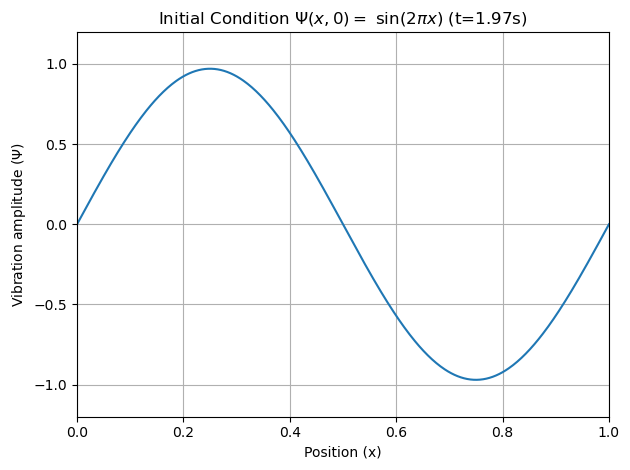

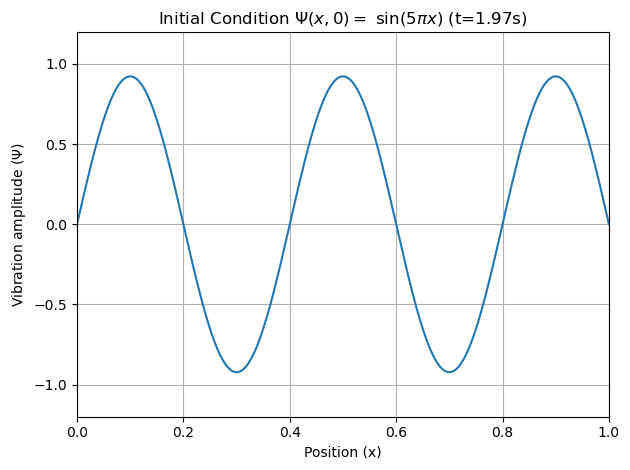

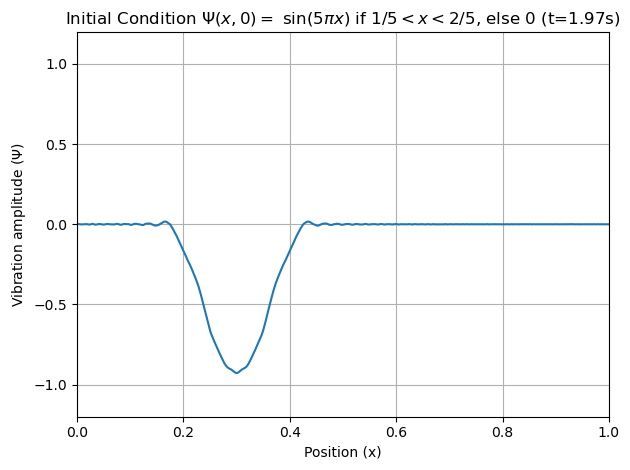

In [25]:
def animate_wave(psi, title, file_title, L=1.0, T=1.0, total_frames=100, save=False):
    fig, ax = plt.subplots(layout='tight')
    x = np.linspace(0, L, psi.shape[0])
    plt.xlim(0, L)
    plt.ylim(-1.2, 1.2)
    plt.xlabel('Position (x)')
    plt.ylabel('Vibration amplitude ($\\Psi$)')
    plt.grid(True)
    line, = ax.plot(x, psi[:,0])

    # Calculate the frame interval based on the total number of frames
    frame_interval = int(psi.shape[1] / total_frames)

    def animate(i):
        line.set_ydata(psi[:,i * frame_interval])
        plt.title(title + f' (t={i * frame_interval / psi.shape[1] * T:.2f}s)')
        return line,

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1000//60, blit=True, repeat=True)
    if save:
        anim.save(f'media/{file_title}.gif', writer='ffmpeg')

# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 2.0
Nx = 500
dx = L / Nx
Nt = int(T / dt)

for i, (init_condition, init_label) in tqdm(enumerate(zip(init_conditions, init_labels)), total=len(init_conditions), desc='Animating wave', unit='animation'):
    psi = solve_wave(init_condition, L, c, T, Nx, dt)
    anim = animate_wave(psi, f'Initial Condition $\\Psi(x,0) =$ {init_label}', f'animated_wave_{i}', T=T, total_frames=80, save=True)

### 1.2: Time Dependent Diffusion Equation

D. (0.5 point) Determine the equation to use at the boundaries of the domain.
Clearly show the ranges of the indices of the grid. A figure is extremely helpful for
figuring this out.

Simulating diffusion: 100%|██████████| 20000/20000 [00:00<00:00, 55317.84step/s]


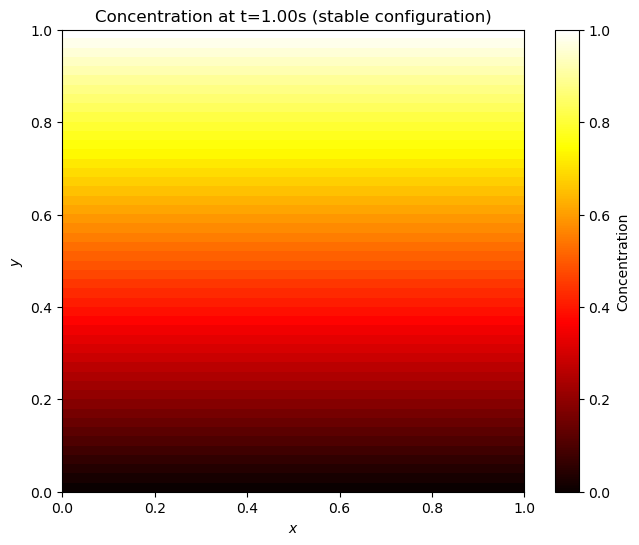

In [26]:
# Parameters
D = 1 # Diffusion coefficient
L = 1 # Length of the square spatial domain

T = 1.0
dt = 0.01
Nx = 50
dx = L / Nx

# Adjust time step based on stability condition
dt_stable = (dx**2) / (4 * D)  # Stability condition for dt
if dt > dt_stable:
    # TODO: double-checking @Jonas
    dt = dt_stable / 2  # Choose a dt smaller than the maximum stable dt to ensure stability 
Nt = int(T / dt)

# Initial & boundary conditions
c = np.zeros((Nx, Nx))
c[:, 0] = 0  # c(x, y=0) = 0
c[:, -1] = 1  # c(x, y=L) = 1

# Update function using vectorized operations for better performance
def update_vectorized(u):
    u_new = np.copy(u)
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + (D * dt / dx**2) * (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1])
    
    # Apply boundary conditions
    u_new[0, :] = u_new[-2, :]
    u_new[-1, :] = u_new[1, :]

    return u_new

# Re-run simulation with adjusted dt and vectorized update
for _ in tqdm(range(Nt), desc='Simulating diffusion', unit='step'):
    c = update_vectorized(c)

# Plotting the final state after adjustments
plt.figure(figsize=(8, 6))
plt.imshow(np.rot90(c, 3), origin='lower', cmap='hot', extent=(0, L, 0, L)) # TODO: cheated, this seems off
plt.colorbar(label='Concentration')
plt.title(f'Concentration at t={T:.2f}s (stable configuration)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.savefig('media/diffusion_stable.png', dpi=300, bbox_inches='tight')
plt.show()

E. (1 point) Test the correctness of your simulation. Compare to the analytic
solutions, plot c(y) for different times.

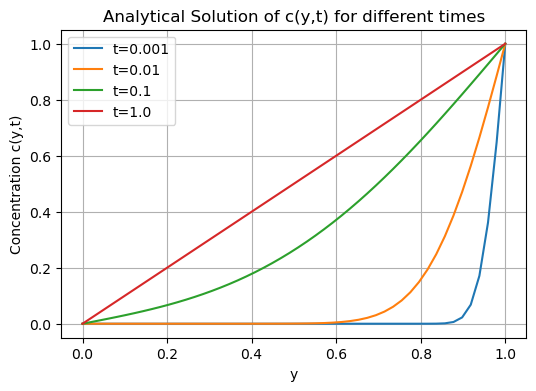

In [27]:
# Parameters and discretization identical to before

def solve_diffusion_analytical(y, t, terms=50):
    """Computes the analytical solution of the concentration c(y,t) using the error function."""
    result = 0
    for i in range(terms):
        result += erfc((1 - y + 2*i) / np.sqrt(4*D*t)) - erfc((1 + y + 2*i) / np.sqrt(4*D*t))
    return result

y_values = np.linspace(0, L, Nx)
time_values = np.logspace(-3, 0, 4)

plt.figure(figsize=(6, 4))
for t in time_values:
    plt.plot(y_values, solve_diffusion_analytical(y_values, t), label=f't={t}')

plt.title('Analytical Solution of c(y,t) for different times')
plt.xlabel('y')
plt.ylabel('Concentration c(y,t)')
plt.legend()
plt.grid(True)
plt.savefig('media/diffusion_analytical.png', dpi=300, bbox_inches='tight')
plt.show()


F. (1 point) Plot the results, show the 2D domain, with a color representing the
concentration at each point. Make a plot of the state of the system at several times:
t = {0, 0.001, 0.01, 0.1, and 1}.

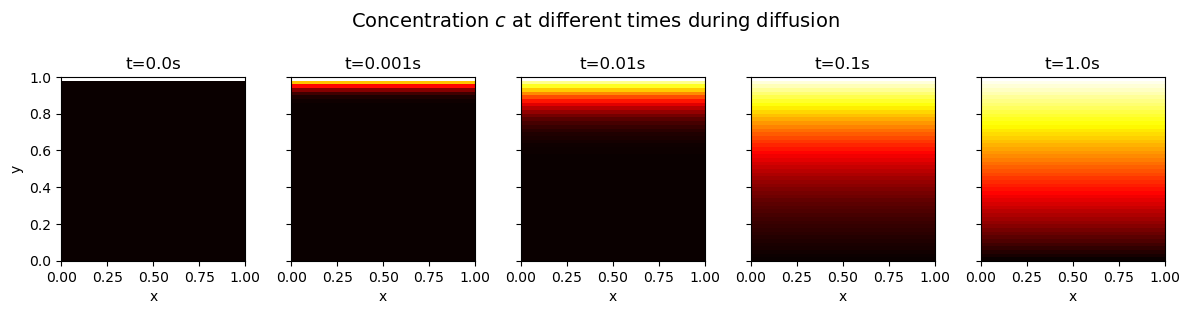

In [28]:
# Adjusted simulation to capture specific time states with a tolerance for floating-point comparison
def solve_diffusion(Nx, D, dx, dt, T):
    """
    Simulate diffusion (2D spatial + time) and return the concentration matrix.

    Parameters:
    - Nx: Number of spatial grid points in each dimension
    - D: Diffusion constant
    - dx: Distance between grid points
    - dt: Time step size
    - T: Total time to simulate

    Returns:
    - c: Concentration matrix at each time step
    """
    Nt = int(T / dt)

    # Initial & boundary conditions
    c = np.zeros((Nx, Nx, Nt + 1))
    c[:, 0] = 0
    c[:, -1] = 1
    
    for t in range(1, Nt + 1):
        c[1:-1, 1:-1, t] = c[1:-1, 1:-1, t-1] + (D * dt / dx**2) * (
            c[2:, 1:-1, t-1] + c[:-2, 1:-1, t-1] + c[1:-1, 2:, t-1] + c[1:-1, :-2, t-1] - 4 * c[1:-1, 1:-1, t-1])
        # Periodic boundary conditions
        c[0, :, t] = c[-2, :, t]
        c[-1, :, t] = c[1, :, t]
    
    return c

# Time points to capture the concentration
times_to_plot = np.array(np.array([0, 0.001, 0.01, 0.1, 1]) * Nt, dtype=int)

# Recalculate the simulation with tolerance for capturing times
c = solve_diffusion(Nx, D, dx, dt, T)

# Plotting with corrected results
fig, axs = plt.subplots(1, len(times_to_plot), figsize=(12, 4), sharey=True, layout='tight')
for i, t in enumerate(times_to_plot):
    axs[i].imshow(np.rot90(c[:,:,t], 3), extent=[0, L, 0, L], origin='lower', cmap='hot') # TODO: cheated, this seems off
    axs[i].set_title(f't={t/Nt}s')
    axs[i].set_xlabel('x')
axs[0].set_ylabel('y')

fig.suptitle('Concentration $c$ at different times during diffusion', y=0.85, fontsize=14)
plt.savefig('media/diffusion_tolerance.png', dpi=300, bbox_inches='tight')
plt.show()


G. (1 point) Make an animated plot of the time dependent diffusion equation until
equilibrium.

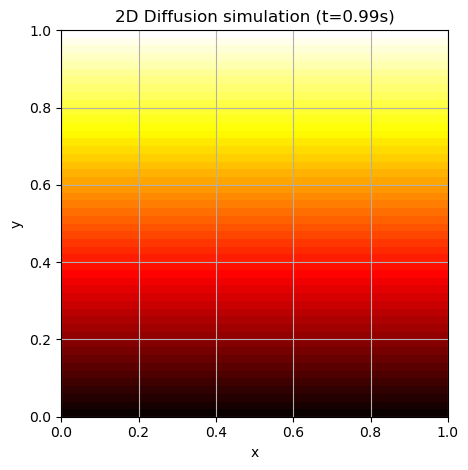

In [29]:
def animate_diffusion(c, title, file_title, L, T, total_frames=100, save=False):
    fig, _ = plt.subplots(layout='tight')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    grid = plt.imshow(np.rot90(c[:,:,0], 3), extent=[0, L, 0, L], origin='lower', cmap='hot')

    # Calculate the frame interval based on the total number of frames
    frame_interval = int(c.shape[2] / total_frames)

    def animate(i):
        grid.set_data(np.rot90(c[:,:, i * frame_interval], 3))
        plt.title(title + f' (t={i * frame_interval / c.shape[2] * T:.2f}s)')
        return grid,

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1000//60, blit=True, repeat=True)
    if save:
        anim.save(f'media/{file_title}.gif', writer='ffmpeg')

c = solve_diffusion(Nx, D, dx, dt, T)
anim = animate_diffusion(c, f'2D Diffusion simulation', f'2d_diffusion_simulation', L=L, T=T, total_frames=80, save=True)

### Laplace Equation

H. (1 point) Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
Try N = 50. Test the methods by comparing the result to the analytical result in
eq. (5), i.e. the linear dependence of the concentration on y.

In [30]:
def jacobi(c, Nx):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c_new[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c_new

def gauss_seidel(c, Nx):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

def sor_iter(c, Nx, omega):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    return c

def check_convergence(c_old, c_new):
    return np.max(np.abs(c_new - c_old)) 

def solve_laplace(method, c, Nx, epsilon, omega=None):
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c, Nx)
        elif method == 'gs':
            c = gauss_seidel(c, Nx)
        elif method == 'sor':
            c = sor_iter(c, Nx, omega)
        iteration += 1
        if check_convergence(c_old, c) < epsilon:
            break
    return c, iteration

# Discretization
Nx = 50
x = np.linspace(0, 1, Nx+2)
y = np.linspace(0, 1, Nx+2)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Parameters
sor_omega = 1.9
epsilon = 1e-5  # checking for convergence

# Initial conditions
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1

# Solve the Laplace equation using different methods
c_jacobi, iterations_jacobi = solve_laplace('jacobi', c.copy(), Nx, epsilon)
print(f'Jacobi method: {iterations_jacobi} iter')
c_gs, iterations_gs = solve_laplace('gs', c.copy(), Nx, epsilon)
print(f'Gauss-Seidel method: {iterations_gs} iter')
c_sor, iterations_sor = solve_laplace('sor', c.copy(), Nx, epsilon, sor_omega)
print(f'Successive Over-Relaxation (SOR) method: {iterations_sor} iter')

Jacobi method: 2288 iter
Gauss-Seidel method: 1340 iter
Successive Over-Relaxation (SOR) method: 120 iter


In [31]:
# Analytical solution (assuming a linear dependence on y)
c_analytical = np.zeros((Nx+2, Nx+2))
for i in range(Nx+2):
    c_analytical[:, i] = y # TODO: doesn't seem right

# Calculate errors compared to analytical solution
error_jacobi = np.abs(c_jacobi - c_analytical)
error_gs = np.abs(c_gs - c_analytical)
error_sor = np.abs(c_sor - c_analytical)

# Maximum error
max_error_jacobi = np.max(error_jacobi)
max_error_gs = np.max(error_gs)
max_error_sor = np.max(error_sor)

print(f'Max error (Jacobi): {max_error_jacobi}')
print(f'Max error (Gauss-Seidel): {max_error_gs}')
print(f'Max error (SOR): {max_error_sor}')

Max error (Jacobi): 1.0
Max error (Gauss-Seidel): 1.0
Max error (SOR): 1.0


In [32]:
# Mean Squared Error
mse_jacobi = np.mean((c_analytical - c_jacobi) ** 2)
mse_gs = np.mean((c_analytical - c_gs) ** 2)
mse_sor = np.mean((c_analytical - c_sor) ** 2)

# Root Mean Squared Error
rmse_jacobi = np.sqrt(mse_jacobi)
rmse_gs = np.sqrt(mse_gs)
rmse_sor = np.sqrt(mse_sor)

print(f'RMSE (Jacobi): {rmse_jacobi:.4f}')
print(f'RMSE (Gauss-Seidel): {rmse_gs:.4f}')
print(f'RMSE (SOR): {rmse_sor:.4f}')

RMSE (Jacobi): 0.4749
RMSE (Gauss-Seidel): 0.4743
RMSE (SOR): 0.4738


I. (1 point) Show how the convergence measure δ in eq. (14) depends on the number
of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
choose a few representative values for ω.

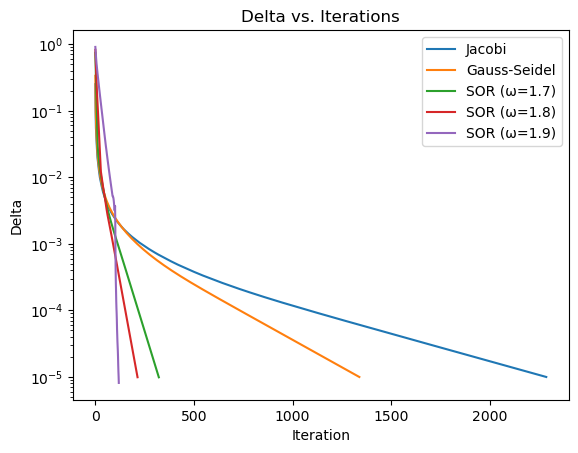

In [33]:
def track_delta(method, c, Nx, omega=None):
    """Counts the number of iterations for each method to converge and returns the deltas (change in c) over time."""
    deltas = []
    epsilon = 1e-5
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi(c, Nx)
        elif method == 'gs':
            c = gauss_seidel(c, Nx)
        elif method == 'sor':
            c = sor_iter(c, Nx, omega)
        delta = np.max(np.abs(c_old - c))
        deltas.append(delta)
        iteration += 1
        if delta < epsilon:
            break
    return deltas

c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_jacobi = track_delta('jacobi', c.copy(), Nx)

c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_gs = track_delta('gs', c.copy(), Nx)

omega_values = [1.7, 1.8, 1.9]
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_sor = {omega: track_delta('sor', c.copy(), Nx, omega) for omega in omega_values}

# Plotting deltas against iterations
plt.plot(delta_jacobi, label='Jacobi')
plt.plot(delta_gs, label='Gauss-Seidel')
for sor_omega, deltas in delta_sor.items():
    plt.plot(deltas, label=f'SOR (ω={sor_omega})')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.title('Delta vs. Iterations')
plt.legend()
plt.show()

J. (1 point) In the SOR method, find the optimal ω. How does it depend on N?.

In [34]:
@jit(nopython=True, parallel=True)
def sor_parallel(c, omega, N, tolerance=1e-6, max_iterations=10000):
    converged = False
    for iteration in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check
        
        # Update red points
        for i in prange(1, N+1):
            for j in range(1, N+1):
                if (i + j) % 2 == 0:
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        
        # Update black points
        for i in prange(1, N+1):
            for j in range(1, N+1):
                if (i + j) % 2 == 1:
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        
        # Convergence check
        diff = np.max(np.abs(c - c_old))
        if diff < tolerance:
            converged = True
            break
    
    return c, iteration, converged

# Function to find the best omega value
def find_best_omega(N, omega_values, tolerance=1e-6, max_iterations=10000):
    best_omega = 0
    min_iterations = max_iterations
    for omega in omega_values:
        c = np.zeros((N+2, N+2))
        c[:, 0] = 0
        c[:, -1] = 1
        _, iterations, converged = sor_parallel(c, omega, N, tolerance, max_iterations)
        if converged and iterations < min_iterations:
            min_iterations = iterations
            best_omega = omega
    return best_omega, min_iterations

# Example usage
N = 100
omega_range = np.linspace(1.7, 2.0, 16)
best_omega, min_iterations = find_best_omega(N, omega_range)
print("Best omega:", best_omega, "with iterations:", min_iterations)

Best omega: 1.94 with iterations: 214


Finding best omega across grid sizes: 100%|██████████| 18/18 [00:47<00:00,  2.64s/grid size]


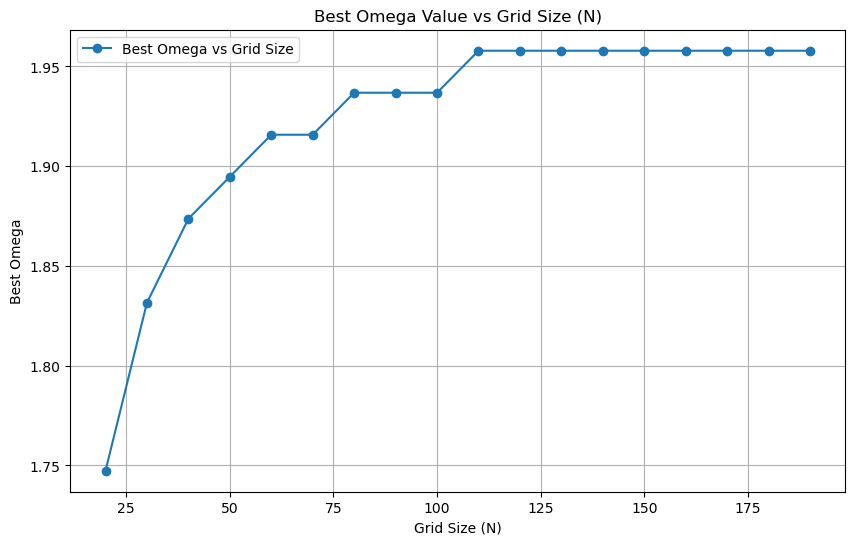

In [36]:
grid_sizes = np.arange(20, 200, 10)
omega_range = np.linspace(1.6, 2, 20)  # Adjust as needed

best_omegas = []
min_iterations_list = []

for N in tqdm(grid_sizes, desc='Finding best omega across grid sizes', unit='grid size'):
    best_omega, min_iterations = find_best_omega(N, omega_range)
    best_omegas.append(best_omega)
    min_iterations_list.append(min_iterations)
    # print(f"Grid Size: {N}, Best Omega: {best_omega:.4f}, Min Iterations: {min_iterations}")

plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, best_omegas, '-o', label='Best Omega vs Grid Size')
plt.xlabel('Grid Size (N)')
plt.ylabel('Best Omega')
plt.title('Best Omega Value vs Grid Size (N)')
plt.grid(True)
plt.legend()
plt.show()


# plt.figure(figsize=(10, 6))
# plt.plot(grid_sizes, min_iterations_list, '-o', label='Min Iterations vs Grid Size')
# plt.xlabel('Grid Size (N)')
# plt.ylabel('Min Iterations')
# plt.title('Minimum Iterations Required vs Grid Size (N)')
# plt.grid(True)
# plt.legend()
# plt.show()


In [ ]:
# # Define grid sizes to test
# grid_sizes = [20, 50, 100]  # different N sizes 
# omega_range = np.linspace(1.7, 2.0, 5)  # range of omega to test


# # find optimal ω for different grid sizes
# # def omega_parameter(grid_sizes, omega_range):
# optimal_omegas = {}
# for Nx in grid_sizes:
#     iterations_for_omegas = []
#     for omega in omega_range:
#         # Setup the grid and boundary conditions again for each N
#         c = np.zeros((Nx+2, Nx+2))  
#         y_list = np.linspace(0, 1, Nx+2)
#         c[:, 0] = y_list  
#         c[:, -1] = y_list 
#         _, iterations = solve_laplace('sor', c.copy(), omega)
#         iterations_for_omegas.append(iterations)
    
#     # Omega with least iterations
#     min_iterations = min(iterations_for_omegas)
#     optimal_omega = omega_range[iterations_for_omegas.index(min_iterations)]
#     optimal_omegas[Nx] = (optimal_omega, min_iterations)

#     # return optimal_omegas


# # best_omega = omega_parameter(grid_sizes, omega_range)
# # best_omega

K. (2 points) Implement the possibility to include objects into the computational
domain. The objects should be sinks. Experiment a little bit with some objects in
the computational domain (e.g. a rectangle or a few rectangles, ...). What is the
influence on the number of iterations. What about the optimal ω , is it influenced
by the presence of objects? Look at the resulting concentration fields, and try to
interpret what happens. The implementation in this exercise will also be used for
diffusion-limited aggregation in Set 2.

Converged in 273 iterations


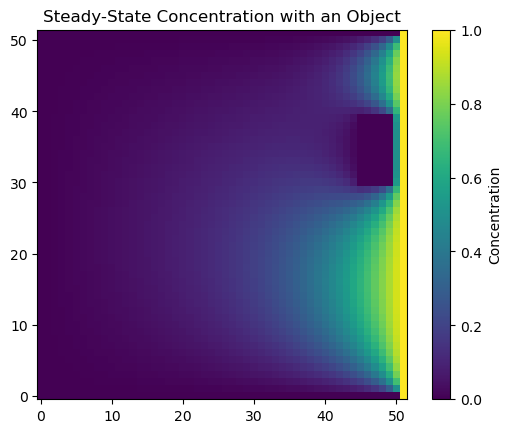

In [ ]:
# Parameters
Nx = 50  # Grid size
omega = 1.7  # Over-relaxation parameter, to be adjusted based on experimentation
epsilon = 1e-5  # Convergence criteria
max_iterations = 10000  # Maximum number of iterations to prevent infinite loops

# Initialize the computational grid
c = np.zeros((Nx+2, Nx+2))
# Boundary conditions
c[:, 0] = 0
c[:, -1] = 1 

# a rectangular object encoded in the domain
objects = np.zeros((Nx+1, Nx+1), dtype=int)
objects[3*Nx//5:4*Nx//5, 9*Nx//10:Nx] = 1  # Representing the object as a rectangle

def update(c, objects):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            if objects[i, j] == 0:  # Check if the point is not part of an object
                c_new[i, j] = (1 - omega) * c[i, j] + (omega / 4) * (
                    c[i+1, j] + c_new[i-1, j] + c[i, j+1] + c_new[i, j-1]
                )
            else:
                c_new[i, j] = 0  # Set concentration to zero if it's part of an object
    return c_new

# Iteration
for iteration in tqdm(range(max_iterations), desc='Simulating SOR with sink', unit='iteration'):
    c_new = update(c, objects)
    # Check for convergence
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations")
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence")

# Plotting
plt.imshow(c, interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-State Concentration with an Object')
plt.savefig("media/simple-object.jpg")


Optional. (1 point) Think of a way to incorporate objects with insulating material in your domain. What changes in the time evolution of the system? And in the ﬁnal state?

Converged in 273 iterations


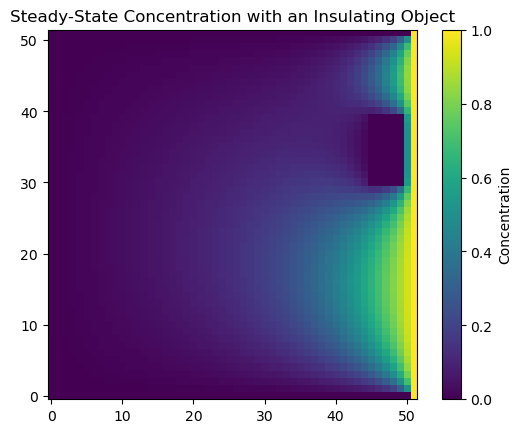

In [ ]:
# Parameters
Nx = 50  # Grid size
omega = 1.7  # Over-relaxation parameter
epsilon = 1e-5  # Convergence criteria
max_iterations = 10000  # Maximum number of iterations to prevent infinite loops

# Initialize the computational grid
c = np.zeros((Nx+2, Nx+2))
# Boundary conditions
c[:, 0] = 0  # Bottom
c[:, -1] = 1  # Top

# a rectangular object encoded in the domain
# adjust to include an insulating object
# 0: Normal point, 1: Sink, 2: Insulator
objects = np.zeros((Nx+1, Nx+1), dtype=int)
objects[3*Nx//5:4*Nx//5, 9*Nx//10:Nx] = 2  # Representing the object as a rectangle

def update_with_insulator(c, objects):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            if objects[i, j] == 1:  # Sink
                c_new[i, j] = 0
            elif objects[i, j] == 2:  # Insulator, enforce no-flux boundary by not updating these edges
                pass  # No action needed, concentration remains unchanged
            else:  # Normal update rule
                c_new[i, j] = (1 - omega) * c[i, j] + (omega / 4) * (
                    c[i+1, j] + c_new[i-1, j] + c[i, j+1] + c_new[i, j-1]
                )
    return c_new

# Re-initialize the concentration matrix
c = np.zeros((Nx+2, Nx+2))
c[:, 0] = 0
c[:, -1] = 1

# Iteration with insulating object
for iteration in tqdm(range(max_iterations), desc='Simulating SOR with Insulator', unit='iteration'):
    c_new = update_with_insulator(c, objects)
    # Check for convergence
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations") # Iteration starts at 0
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence")

# Plotting
plt.imshow(c, interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-State Concentration with an Insulating Object')
# plt.show()
plt.savefig("media/insulating.jpg")

In [52]:
def update_with_insulation(c, objects):
    c_new = c.copy()
    for i in range(1, N):
        for j in range(1, N):
            if objects[i, j] == 0:  # Not part of an object
                contributions = []
                # Check each neighbor and add it to the contributions if it's not an insulating material
                if objects[i+1, j] != 2:
                    contributions.append(c[i+1, j])
                if objects[i-1, j] != 2:
                    contributions.append(c_new[i-1, j])
                if objects[i, j+1] != 2:
                    contributions.append(c[i, j+1])
                if objects[i, j-1] != 2:
                    contributions.append(c_new[i, j-1])

                # Calculate new concentration based on available contributions
                if contributions:
                    c_new[i, j] = (1 - omega) * c[i, j] + omega * sum(contributions) / len(contributions)
                else:
                    c_new[i, j] = c[i, j]  # No update if completely surrounded by insulators
            # No else case needed; insulating objects do not change concentration
    return c_new

# Adjusting the previous implementation to incorporate insulating objects
# For simplicity, we'll use the same object matrix but now treat it as insulating
objects = np.zeros((Nx+2, Nx+2), dtype=int)
objects[1*Nx//5:5*Nx//5, 9*Nx//10:Nx] = 2

# Iteration with insulating objects
c = np.zeros((N+1, N+1))  # Reset concentration grid
c[:, 0] = 0  # Bottom boundary condition
c[:, -1] = 1  # Top boundary condition

for iteration in range(max_iterations):
    c_new = update_with_insulation(c, objects)
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations with insulating objects")
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence with insulating objects")

# Plotting
plt.imshow(c, interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-State Concentration with Insulating Object')
plt.show()

IndexError: index 52 is out of bounds for axis 1 with size 52